In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
print("✅ All imports successful!")

✅ All imports successful!


In [2]:

# datasets
labels = pd.read_csv("Data/labels.csv")
#sample = pd.read_csv('/content/drive/My Drive/dog/sample_submission.csv')

# folders paths
train_path = "Data/train"
test_path = "Data/test"
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [3]:
if labels['id'][0].endswith('.jpg')==False:
    labels['id']= labels['id'].apply(lambda x: str(x)+'.jpg')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=15.0,
    fill_mode='nearest',
    validation_split=0.1
)

# Validation data generator — only rescale, NO augmentation
val_gen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.1
)

# Flow from dataframe
train_generator = train_gen.flow_from_dataframe(
    labels,
    directory=train_path,
    x_col='id',
    y_col='breed',
    subset="training",
    color_mode="rgb",
    target_size=(331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

validation_generator = val_gen.flow_from_dataframe(
    labels,
    directory=train_path,
    x_col='id',
    y_col='breed',
    subset="validation",
    color_mode="rgb",
    target_size=(331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,  # keep deterministic order
    seed=42
)


Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


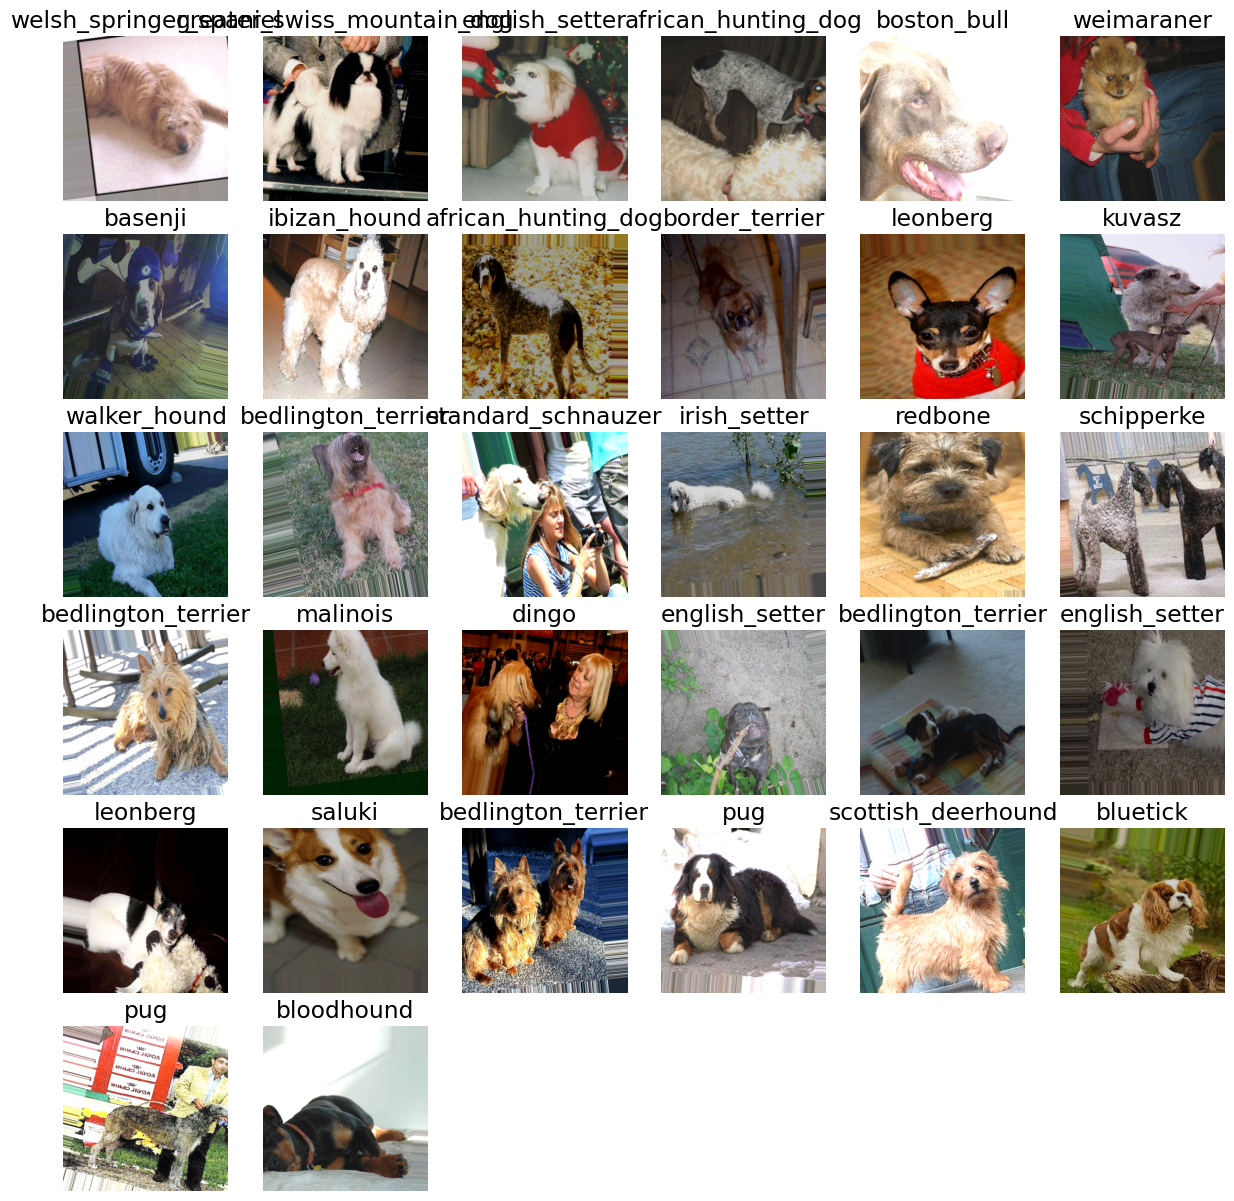

In [33]:
x,y = next(train_generator)
plt.figure(figsize=(15, 15)) 
for i in range(x.shape[0]): # input shape of one record is (331,331,3) , 32: is the batch size
    plt.subplot(6, 6, i+1)
    plt.axis('off')
    plt.title(labels['breed'][np.argmax(y[i])])
    plt.imshow(x[i])

In [5]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False

# Build the model and pass an input with a defined shape 
# so the model can infer the shapes of all the layers
input_tensor = tf.keras.Input(shape=(331,331,3))
output_tensor = base_model(input_tensor)

# Now build the rest of the model
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

# This code is modified by Susobhan Akhuli

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 9, 9, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,309,528 (210.99 MB)

 Trainable params: 969,720 (3.70 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [7]:
early = tf.keras.callbacks.EarlyStopping( patience=5,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)
# save the best model during the trining 

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early,checkpoint])

# This code is modified by Susobhan Akhuli

Epoch 1/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0119 - loss: 4.9210

287/287 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.0217 - loss: 4.8154 - val_accuracy: 0.1149 - val_loss: 4.5353
Epoch 2/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:08 1s/step - accuracy: 0.0625 - loss: 4.6409

287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.0625 - loss: 4.6409 - val_accuracy: 0.1149 - val_loss: 4.5336
Epoch 3/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0544 - loss: 4.5249

287/287 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.0782 - loss: 4.4155 - val_accuracy: 0.3407 - val_loss: 4.0016
Epoch 4/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:09 1s/step - accuracy: 0.0625 - loss: 4.2870

287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.0625 - loss: 4.2870 - val_accuracy: 0.3417 - val_loss: 3.9997
Epoch 5/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1511 - loss: 4.1303

287/287 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.1799 - loss: 4.0308 - val_accuracy: 0.5948 - val_loss: 3.4607
Epoch 6/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:26 1s/step - accuracy: 0.2500 - loss: 3.7174

287/287 ━━━━━━━━━━━━━━━━━━━━ 1095s 4s/step - accuracy: 0.2500 - loss: 3.7174 - val_accuracy: 0.5938 - val_loss: 3.4587
Epoch 7/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2764 - loss: 3.7065 

287/287 ━━━━━━━━━━━━━━━━━━━━ 3926s 14s/step - accuracy: 0.3060 - loss: 3.6001 - val_accuracy: 0.7167 - val_loss: 2.8759
Epoch 8/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.3125 - loss: 3.4253

287/287 ━━━━━━━━━━━━━━━━━━━━ 84s 285ms/step - accuracy: 0.3125 - loss: 3.4253 - val_accuracy: 0.7198 - val_loss: 2.8741
Epoch 9/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.4044 - loss: 3.2347 

287/287 ━━━━━━━━━━━━━━━━━━━━ 5219s 18s/step - accuracy: 0.4235 - loss: 3.1420 - val_accuracy: 0.7893 - val_loss: 2.2739
Epoch 10/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 10:46 2s/step - accuracy: 0.5625 - loss: 2.8022

287/287 ━━━━━━━━━━━━━━━━━━━━ 83s 283ms/step - accuracy: 0.5625 - loss: 2.8022 - val_accuracy: 0.7903 - val_loss: 2.2721
Epoch 11/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.4972 - loss: 2.7943 

287/287 ━━━━━━━━━━━━━━━━━━━━ 6835s 24s/step - accuracy: 0.5278 - loss: 2.6738 - val_accuracy: 0.8276 - val_loss: 1.7262
Epoch 12/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 10:27 2s/step - accuracy: 0.3438 - loss: 3.0928

287/287 ━━━━━━━━━━━━━━━━━━━━ 81s 275ms/step - accuracy: 0.3438 - loss: 3.0928 - val_accuracy: 0.8276 - val_loss: 1.7242
Epoch 13/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5983 - loss: 2.3400

287/287 ━━━━━━━━━━━━━━━━━━━━ 1759s 6s/step - accuracy: 0.6145 - loss: 2.2543 - val_accuracy: 0.8619 - val_loss: 1.2821
Epoch 14/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 12:11 3s/step - accuracy: 0.4375 - loss: 2.6983

287/287 ━━━━━━━━━━━━━━━━━━━━ 1050s 4s/step - accuracy: 0.4375 - loss: 2.6983 - val_accuracy: 0.8619 - val_loss: 1.2807
Epoch 15/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6713 - loss: 1.9512 

287/287 ━━━━━━━━━━━━━━━━━━━━ 5510s 19s/step - accuracy: 0.6846 - loss: 1.8685 - val_accuracy: 0.8770 - val_loss: 0.9549
Epoch 16/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 10:04 2s/step - accuracy: 0.6875 - loss: 1.6792

287/287 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.6875 - loss: 1.6792 - val_accuracy: 0.8770 - val_loss: 0.9542
Epoch 17/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7231 - loss: 1.6260

287/287 ━━━━━━━━━━━━━━━━━━━━ 875s 3s/step - accuracy: 0.7292 - loss: 1.5740 - val_accuracy: 0.8911 - val_loss: 0.7314
Epoch 18/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 11:24 2s/step - accuracy: 0.8125 - loss: 1.3831

287/287 ━━━━━━━━━━━━━━━━━━━━ 94s 320ms/step - accuracy: 0.8125 - loss: 1.3831 - val_accuracy: 0.8911 - val_loss: 0.7311
Epoch 19/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7550 - loss: 1.3746

287/287 ━━━━━━━━━━━━━━━━━━━━ 1379s 5s/step - accuracy: 0.7595 - loss: 1.3514 - val_accuracy: 0.8952 - val_loss: 0.5889
Epoch 20/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 18:39 4s/step - accuracy: 0.7812 - loss: 1.5700

287/287 ━━━━━━━━━━━━━━━━━━━━ 136s 462ms/step - accuracy: 0.7812 - loss: 1.5700 - val_accuracy: 0.8952 - val_loss: 0.5886
Epoch 21/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7884 - loss: 1.1892

287/287 ━━━━━━━━━━━━━━━━━━━━ 1489s 5s/step - accuracy: 0.7922 - loss: 1.1632 - val_accuracy: 0.9022 - val_loss: 0.4966
Epoch 22/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 20:07 4s/step - accuracy: 0.9688 - loss: 0.8704

287/287 ━━━━━━━━━━━━━━━━━━━━ 151s 511ms/step - accuracy: 0.9688 - loss: 0.8704 - val_accuracy: 0.9022 - val_loss: 0.4962
Epoch 23/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8050 - loss: 1.0662

287/287 ━━━━━━━━━━━━━━━━━━━━ 1799s 6s/step - accuracy: 0.8055 - loss: 1.0405 - val_accuracy: 0.9073 - val_loss: 0.4366
Epoch 24/25
  1/287 ━━━━━━━━━━━━━━━━━━━━ 10:42 2s/step - accuracy: 0.8750 - loss: 0.8214

287/287 ━━━━━━━━━━━━━━━━━━━━ 978s 3s/step - accuracy: 0.8750 - loss: 0.8214 - val_accuracy: 0.9073 - val_loss: 0.4364
Epoch 25/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8141 - loss: 0.9629

287/287 ━━━━━━━━━━━━━━━━━━━━ 1297s 4s/step - accuracy: 0.8165 - loss: 0.9406 - val_accuracy: 0.9093 - val_loss: 0.3991


In [45]:
# keep going
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

start = len(history.history['loss'])   # 25
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=45,                 # new target
    initial_epoch=start,       # continue from 25
    callbacks=[early, checkpoint],
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps=STEP_SIZE_VALID
)


Epoch 26/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8463 - loss: 0.7076

287/287 ━━━━━━━━━━━━━━━━━━━━ 2090s 7s/step - accuracy: 0.8454 - loss: 0.7047 - val_accuracy: 0.9183 - val_loss: 0.3389
Epoch 27/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.8438 - loss: 0.7106 - val_accuracy: 0.9183 - val_loss: 0.3389
Epoch 28/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8513 - loss: 0.6693

287/287 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.8519 - loss: 0.6699 - val_accuracy: 0.9183 - val_loss: 0.3337
Epoch 29/45
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:21 1s/step - accuracy: 0.8438 - loss: 0.7450

287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.8438 - loss: 0.7450 - val_accuracy: 0.9183 - val_loss: 0.3337
Epoch 30/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8594 - loss: 0.6516

287/287 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8578 - loss: 0.6460 - val_accuracy: 0.9183 - val_loss: 0.3296
Epoch 31/45
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:48 1s/step - accuracy: 0.8438 - loss: 0.8492

287/287 ━━━━━━━━━━━━━━━━━━━━ 37s 126ms/step - accuracy: 0.8438 - loss: 0.8492 - val_accuracy: 0.9183 - val_loss: 0.3295
Epoch 32/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8523 - loss: 0.6371

287/287 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8549 - loss: 0.6265 - val_accuracy: 0.9173 - val_loss: 0.3267
Epoch 33/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 37s 127ms/step - accuracy: 0.7500 - loss: 0.7463 - val_accuracy: 0.9173 - val_loss: 0.3268
Epoch 34/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8595 - loss: 0.6469

287/287 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.8605 - loss: 0.6204 - val_accuracy: 0.9143 - val_loss: 0.3263
Epoch 35/45
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:40 1s/step - accuracy: 0.6875 - loss: 1.0180

287/287 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.6875 - loss: 1.0180 - val_accuracy: 0.9143 - val_loss: 0.3263
Epoch 36/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8614 - loss: 0.5883

287/287 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.8613 - loss: 0.5926 - val_accuracy: 0.9163 - val_loss: 0.3224
Epoch 37/45
  1/287 ━━━━━━━━━━━━━━━━━━━━ 14:15 3s/step - accuracy: 0.8438 - loss: 0.8447

287/287 ━━━━━━━━━━━━━━━━━━━━ 105s 358ms/step - accuracy: 0.8438 - loss: 0.8447 - val_accuracy: 0.9173 - val_loss: 0.3222
Epoch 38/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8694 - loss: 0.5630

287/287 ━━━━━━━━━━━━━━━━━━━━ 748s 3s/step - accuracy: 0.8629 - loss: 0.5696 - val_accuracy: 0.9153 - val_loss: 0.3187
Epoch 39/45
  1/287 ━━━━━━━━━━━━━━━━━━━━ 5:28 1s/step - accuracy: 0.9062 - loss: 0.3381

287/287 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.9062 - loss: 0.3381 - val_accuracy: 0.9153 - val_loss: 0.3186
Epoch 40/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8612 - loss: 0.5799

287/287 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.8666 - loss: 0.5602 - val_accuracy: 0.9183 - val_loss: 0.3172
Epoch 41/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - accuracy: 0.8750 - loss: 0.4785 - val_accuracy: 0.9173 - val_loss: 0.3173
Epoch 42/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8646 - loss: 0.5588

287/287 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.8679 - loss: 0.5538 - val_accuracy: 0.9153 - val_loss: 0.3153
Epoch 43/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.8125 - loss: 0.4412 - val_accuracy: 0.9153 - val_loss: 0.3154
Epoch 44/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.8697 - loss: 0.5382 - val_accuracy: 0.9123 - val_loss: 0.3159
Epoch 45/45
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - accuracy: 0.9062 - loss: 0.3787 - val_accuracy: 0.9123 - val_loss: 0.3160


In [9]:
import pickle

model.save("Model_agmen_10_LLR.h5")

# Save
with open('Model_agmen_10_LLR.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [12]:
import pickle
import types
history = types.SimpleNamespace()

#model.load_weights("Model.h5")
model.load_weights("Model_agmen.h5")
with open('history_agmen.pkl', 'rb') as f:
    history.history= pickle.load(f)


Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.90625\nValidation Accuracy: 0.9122983813285828')

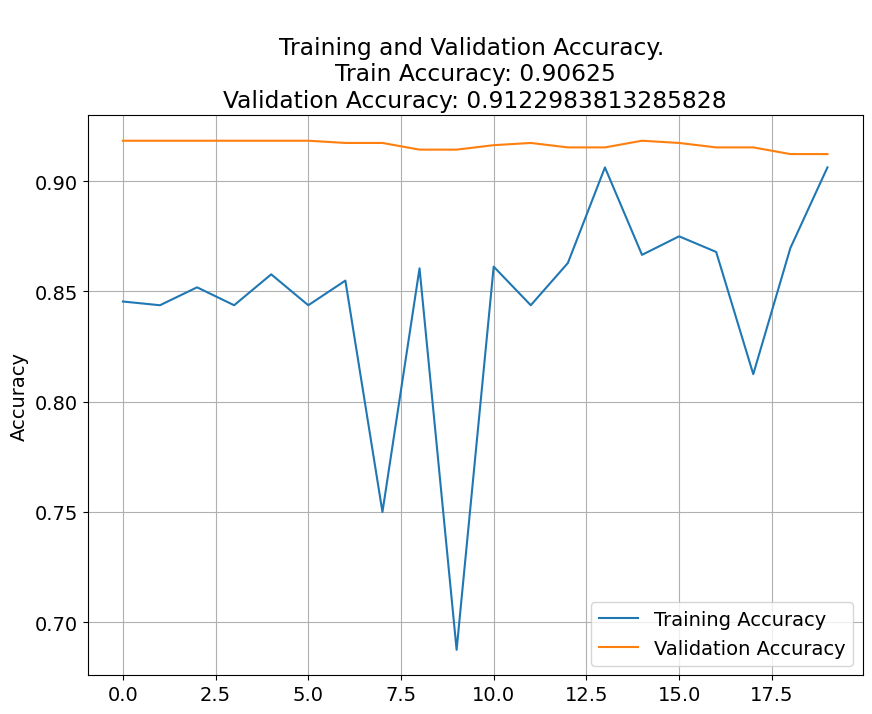

In [46]:
# store results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

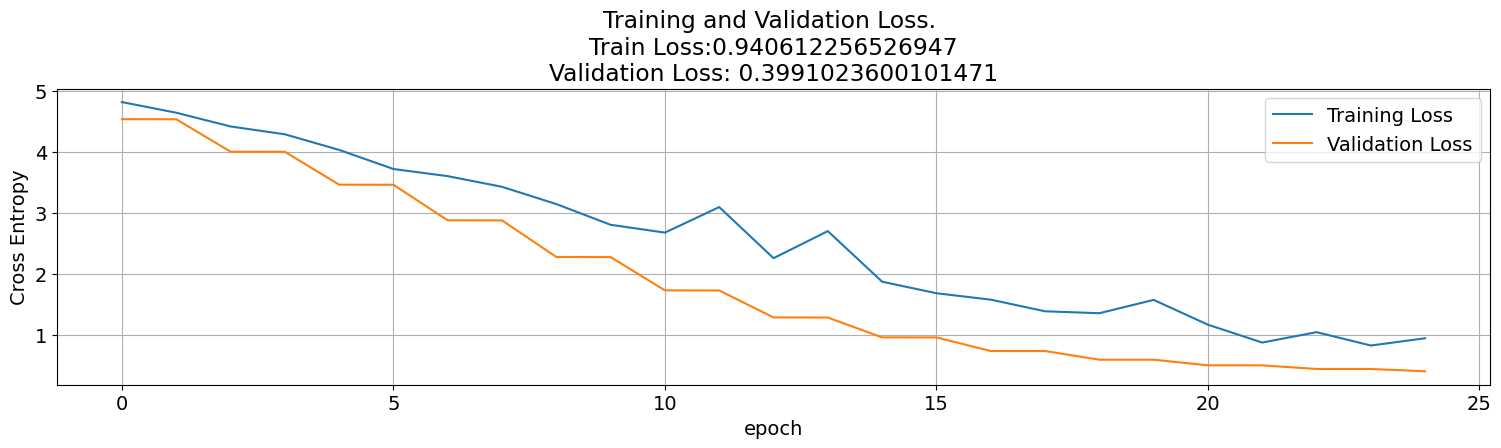

In [11]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:' 
          f'{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [38]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9207 - loss: 0.3401
[0.340109258890152, 0.9207436442375183]
Accuracy: 92.0744%
Loss:  0.340109258890152


In [ ]:
test_img_path = test_path+"/000621fb3cbb32d8935728e48679680e.jpg"


img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

[ WARN:0@1200.675] global loadsave.cpp:275 findDecoder imread_('Data/train/000621fb3cbb32d8935728e48679680e.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [16]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
plt.figure(figsize=(60,60))
c=5
sucess=0
failed=0
for i in range(5000):
    image_name=labels['id'][i+c]
    test_img_path = train_path+'/'+image_name

    img = cv2.imread(test_img_path)
    resized_img = cv2.resize(img, (331, 331))
    normalized_img = preprocess_input(resized_img)
    pred = model.predict(normalized_img.reshape(-1, 331, 331, 3))

    # Step 2: Interpret the result
    # If your model outputs probabilities (common in classification), take the argmax
    predicted_class_index = np.argmax(pred, axis=1)[0]

    # Step 3: Map index → class label
    # Assuming you used a generator like ImageDataGenerator with class_indices:
    labels_map = dict((v, k) for k, v in train_generator.class_indices.items())
    predicted_label = labels_map[predicted_class_index]
    true_label=labels['breed'][i+c]

    # Step 4: Display result
    #subplot = plt.subplot(50, 10, i+1)
    #plt.axis('off')
    if predicted_label == true_label:
        title_color = 'green'
        sucess+=1
    else:
        title_color = 'red'
        failed+=1
    #subplot.set_title(f"P: {predicted_label}\nT: {true_label}",fontsize=12,color=title_color)

    #plt.imshow(resized_img[0])
print("Sucessful predictions: ",sucess)
print("Failed predictions: ",failed) 
print("Total predictions: ",sucess/(sucess+failed)*100)       


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 6000x6000 with 0 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


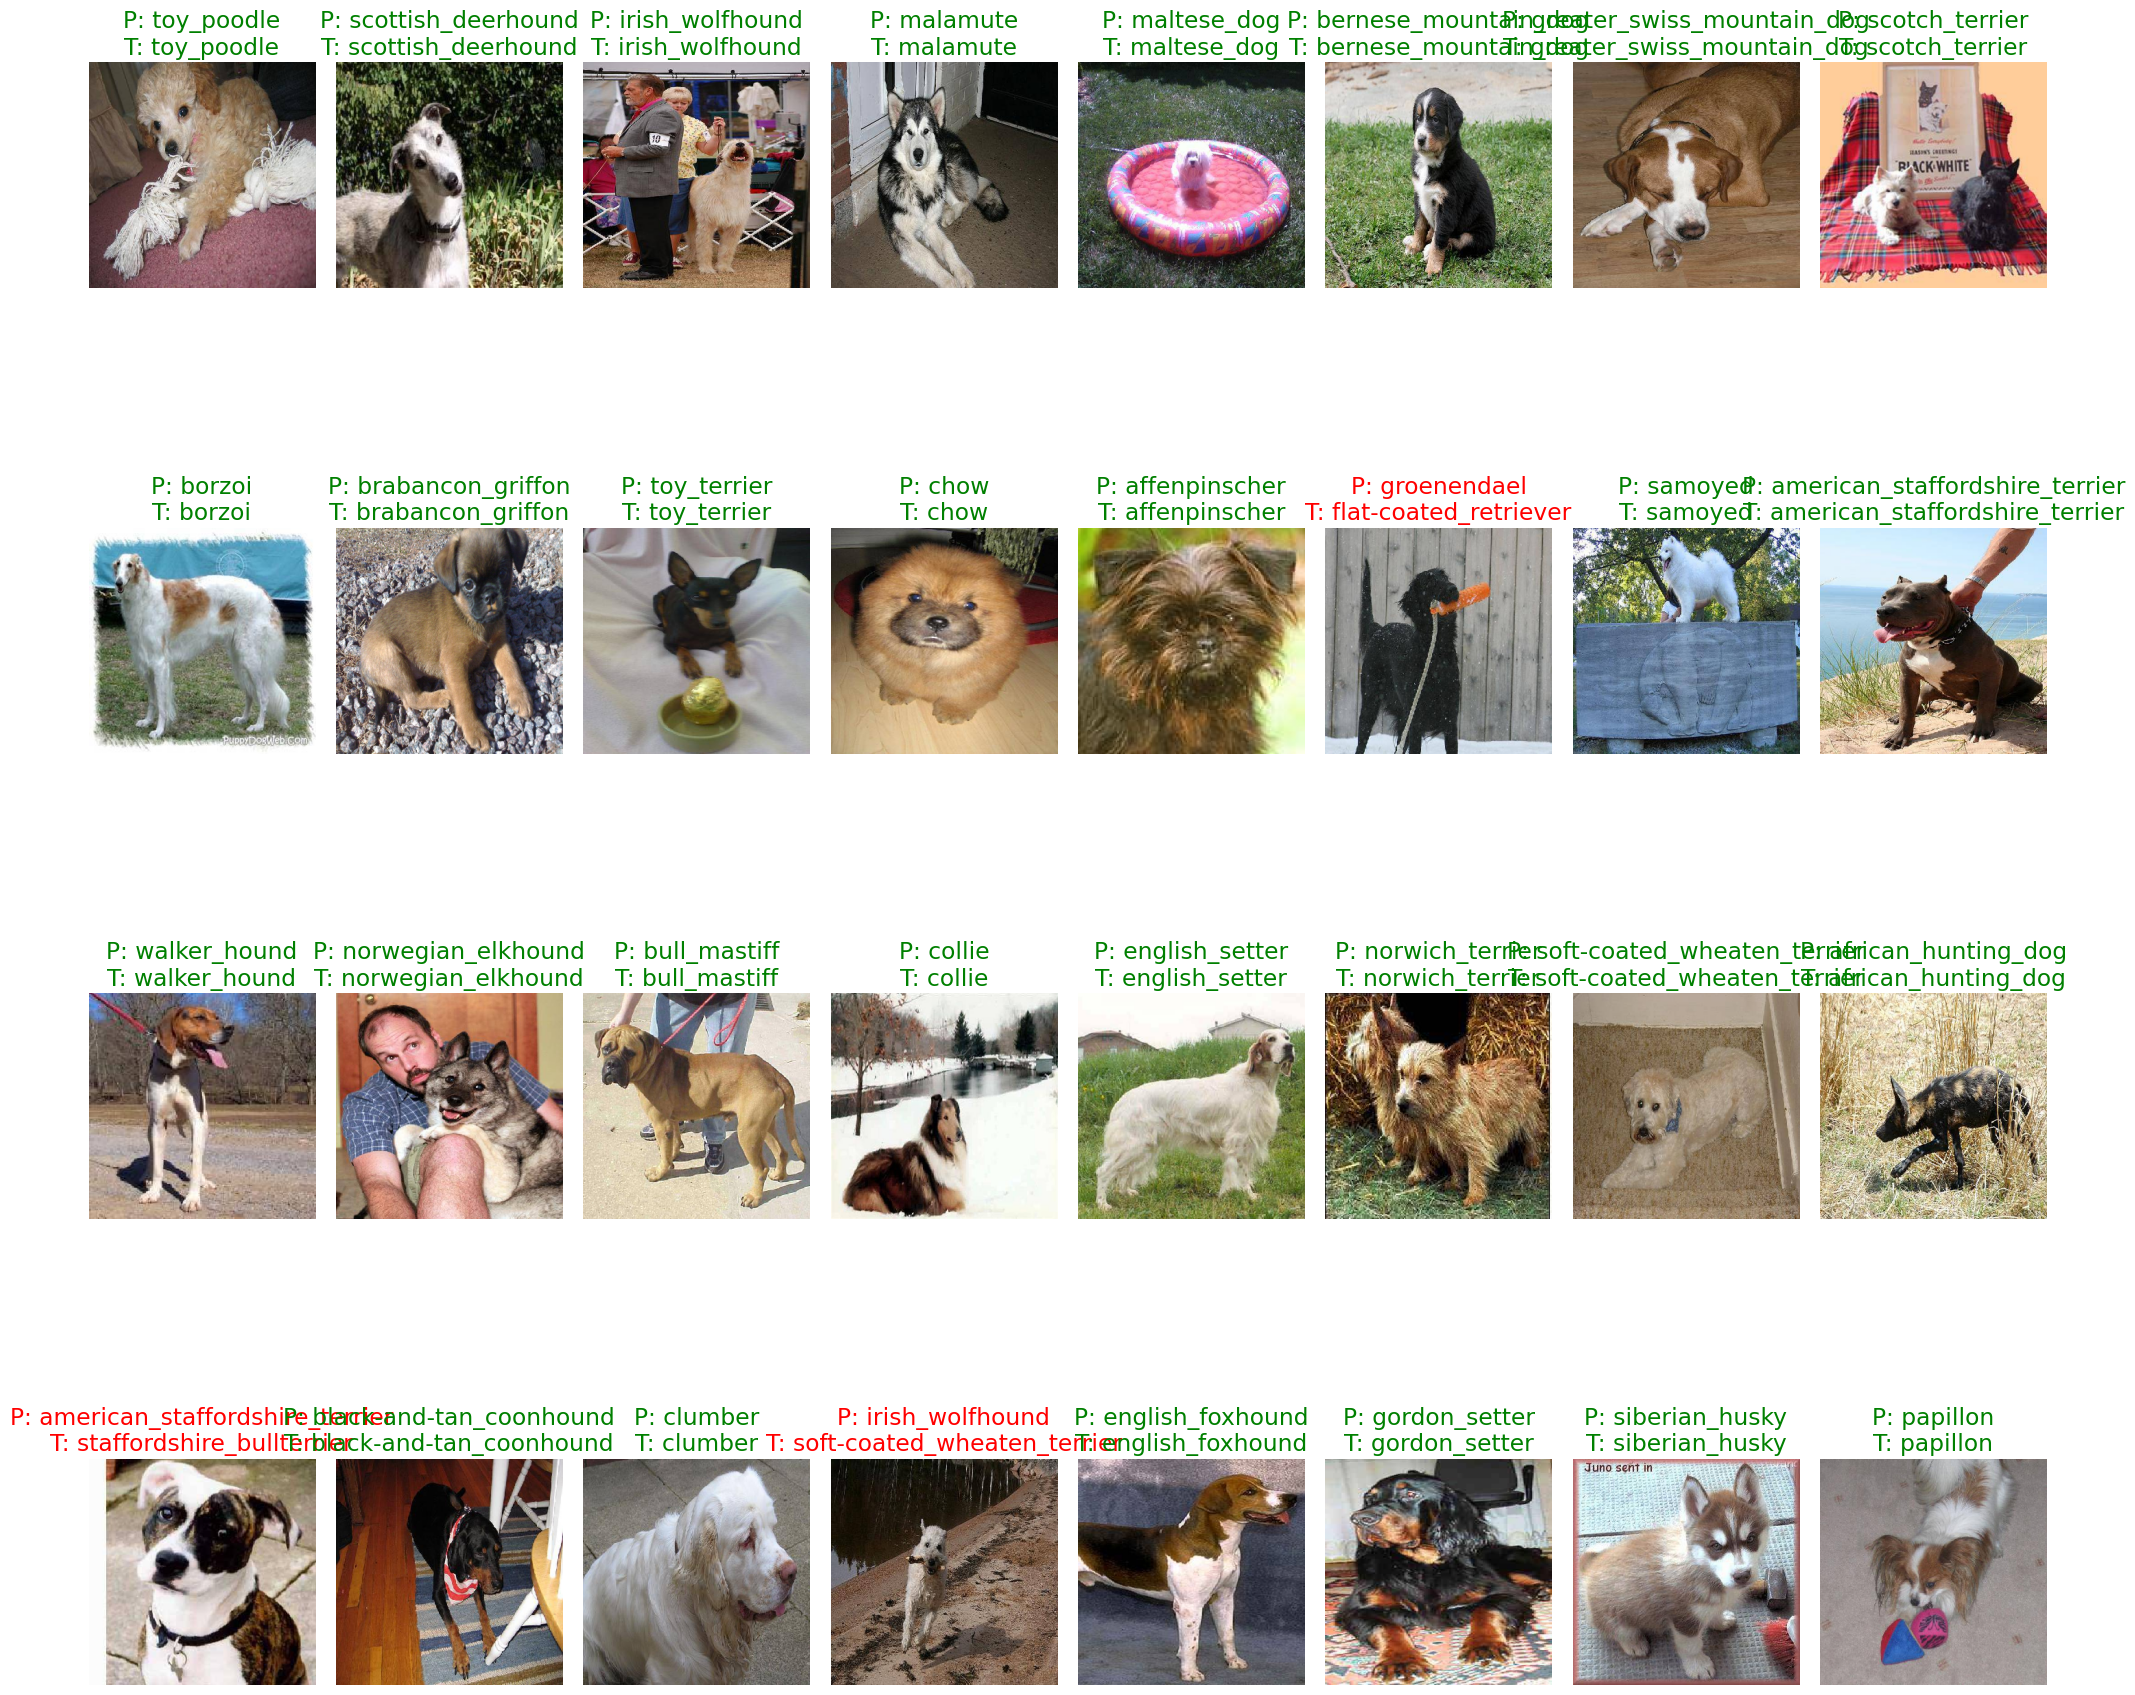

In [55]:

# Get one batch of validation images
x_val, y_val = next(validation_generator)

# Predict on this batch
preds = model.predict(x_val)

# Decode class indices
labels_map = {v: k for k, v in validation_generator.class_indices.items()}

# Plot 12 sample images
plt.figure(figsize=(20, 20))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    true_idx = np.argmax(y_val[i])
    pred_idx = np.argmax(preds[i])
    true_label = labels_map[true_idx]
    pred_label = labels_map[pred_idx]
    
    color = 'green' if true_label == pred_label else 'red'
    plt.imshow(x_val[i])
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


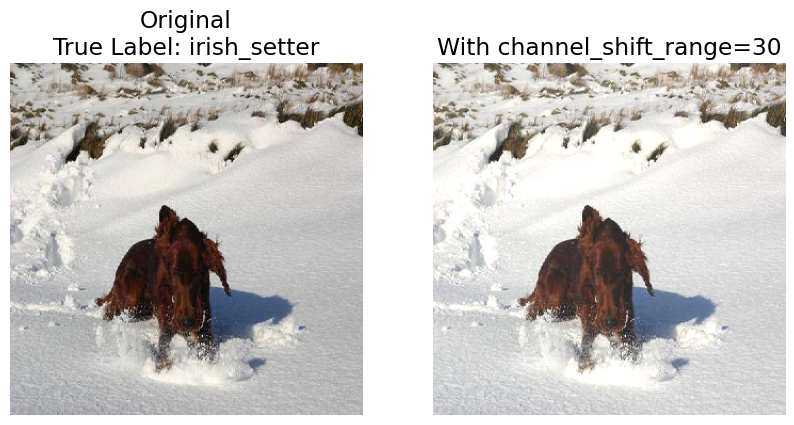

In [35]:


# --- Create the same augmentation you used for training ---
augment = ImageDataGenerator(
    rescale=1./255.,
    channel_shift_range=1   # 🎨 apply strong color tint
)

# --- Take one sample from your validation generator ---
x_val, y_val = next(validation_generator)

# --- Show the original image ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_val[0])
plt.title(f"Original\nTrue Label: {labels_map[np.argmax(y_val[0])]}")
plt.axis('off')

# --- Apply the color augmentation manually to the same image ---
x_img = x_val[0].copy()

# Add +30 to the red channel (channel index 0)
x_img[:, :, 0] = np.clip(x_img[:, :, 0] + 30/255.0, 0, 1)  # if x_val is normalized to 0–1
x_img[:, :, 1] = np.clip(x_img[:, :, 1] + 30/255.0, 0, 1)
x_img[:, :, 2] = np.clip(x_img[:, :, 2] + 30/255.0, 0, 1)
plt.subplot(1,2,2)
plt.imshow(x_img)  # 🎨 simulate channel shift by adding 30 to green channel
plt.title("With channel_shift_range=30")
plt.axis('off')

plt.show()


In [ ]:
# Get one batch of validation images
x_val, y_val = next(validation_generator)

# Predict on this batch
preds = model.predict(x_val)

# Decode class indices
labels_map = {v: k for k, v in validation_generator.class_indices.items()}

# Plot 12 sample images
plt.figure(figsize=(20, 20))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    true_idx = np.argmax(y_val[i])
    pred_idx = np.argmax(preds[i])
    true_label = labels_map[true_idx]
    pred_label = labels_map[pred_idx]
    
    color = 'green' if true_label == pred_label else 'red'
    plt.imshow(x_val[i])
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
